# Analisis Exploratorio de los Datos

En la siguiente notebook se busca entender el dataset y realizar un análisis exploratorio de los datos. El objetivo es entender el problema al que nos enfrentamos, como vienen los datos desde el origen y las variables que se tienen. Una vez identificadas, procederemos a realizar el feature engineering, feature creation, feature selection, feature importance, etc. Finalmente, se rescatara solo la parte del proceso de cleaning y transformaciones/feature engineering para crear el feature_engineering_pipeline.py con los estandares necesarios para correrse en produccion


## 1. Carga y limpieza de datos

In [1]:
import kagglehub
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

# defino el directorio para guardar el set de datos
target_dir = "../data"
os.makedirs(target_dir, exist_ok=True)

# Descargo el set de datos como se indica en Kaggle
path = kagglehub.dataset_download("patelris/crop-yield-prediction-dataset")

# Muevo los archivos del cache al path de data 
for file in os.listdir(path):
    shutil.move(os.path.join(path, file), target_dir)

print("El Set de Datos se encuentra disponible en:", os.path.abspath(target_dir))

El Set de Datos se encuentra disponible en: d:\crop-yield-predictor\crop-yield-predictor\data


* Desde la direccion proporcionada en Kaggle ya viene un dataset unificado 'yield_df', pero luego de inspeccionarlo vemos que tiene aplicadas tecnicas que no son muy convenientes para este analisis. 
* Utilizamos en su lugar solo los dataframes originales que aun no estan procesados, excluyendo tambien el dataset pesticides.csv ya que traemos uno mas desagregado.
* Agregamos por fuera dos bases de datos que se encuentran en http://www.fao.org/home/en/ (pagina mencionada como una de las fuentes de datos) y son interesantes de analizar. La primera es una desagregacion de los pesticidas obtenida de https://www.fao.org/faostat/en/#data/RP y la segunda es el uso de fertilizantes https://www.fao.org/faostat/en/#data/RFB. Explicamos luego porque estas bases pueden aportar mucha informacion. Habia otras bases interesantes como el uso de la tierra para agricultura que se podrian utilizar en un futuro si no se logran buenos predictores con los datos ya recolectados. 

In [2]:
df_yield = pd.read_csv("../data/yield.csv")
df_temp= pd.read_csv("../data/temp.csv")
df_rainfall = pd.read_csv("../data/rainfall.csv")
df_pesticides_by_type = pd.read_csv("../data/pesticides_by_type.csv")
df_fertilizers_by_type = pd.read_csv("../data/fertilizers_by_type.csv")

Eliminamos las columnas que no aportan informacion ya que contienen un solo valor.

In [3]:
def drop_single_value_columns(df, df_name=""):
    """Elimina columnas con un solo valor único"""
    print(f"Las siguientes columnas de {df_name} se eliminan ya que no aportan información:")
    for col in df.columns:
        if df[col].nunique() == 1:
            df = df.drop(columns=[col])
            print(f"'{col}'")
    return df


df_yield = drop_single_value_columns(df_yield, "df_yield")
df_temp = drop_single_value_columns(df_temp, "df_temp") 
df_rainfall = drop_single_value_columns(df_rainfall, "df_rainfall")
df_pesticides_by_type = drop_single_value_columns(df_pesticides_by_type, "df_pesticides_by_type")
df_fertilizers_by_type = drop_single_value_columns(df_fertilizers_by_type, "df_fertilizers_by_type")

Las siguientes columnas de df_yield se eliminan ya que no aportan información:
'Domain Code'
'Domain'
'Element Code'
'Element'
'Unit'
Las siguientes columnas de df_temp se eliminan ya que no aportan información:
Las siguientes columnas de df_rainfall se eliminan ya que no aportan información:
Las siguientes columnas de df_pesticides_by_type se eliminan ya que no aportan información:
'Domain Code'
'Domain'
Las siguientes columnas de df_fertilizers_by_type se eliminan ya que no aportan información:
'Domain Code'
'Domain'
'Element Code'
'Element'
'Unit'


### Base de datos de pesticidas

Como dice el propio informe de FAOSTAT: "Los pesticidas son un insumo agrícola clave que se utiliza para proteger las semillas y resguardar los cultivos de plantas, insectos, bacterias, hongos y roedores no deseados". 

Porque nos sirve? Porque es un mecanismo agronómico directo (controlan adversidades que afectan al maíz). Los **principales tipos a rescatar para el tratamiento del maiz** son:
* **Fungicides and Bactericides**: Epidemias de tizón, roya, etc, reducen el t/ha y el uso de fungicidas suele mejorar el rendimiento medio, dependiendo del timing y clase química.
* **Herbicides**: El control de malezas explica gran parte de la brecha de rendimiento; ensayos sin herbicidas muestran pérdidas >10 %.
* **Insecticides**: Raíces y espigas dañadas por insectos (ej. Diabrotica, Spodoptera) merman el peso del grano.
* Evitamos el element 'Use per value of agricultural production' medido en 'g/Int$' ya que esta relacionada con variables económicas y suele correlacionar con PIB más que con agronomía/rendimientos que es nuestra variable target en este caso.
* Por ultimo, esta desagregacion por tipo de pesticidas puede servir para medir luego interacciones agroclimáticas (analisis multivariado), cruzando cada tipo de pesticida con precipitaciones y temperatura para reflejar presión de enfermedades y malezas!

In [4]:
# elimino otras columnas que no aportan informacion (se podria considerar dejar el Flag en un futuro)
df_pesticides_by_type.drop(['Area Code (M49)', 'Element Code', 'Item Code', 'Year Code', 'Flag', 'Flag Description', 'Note'], axis=1, inplace=True)

In [5]:
# vemos los items disponibles y sus unidades de medida
df_pesticides_by_type[['Element', 'Item','Unit']].drop_duplicates()

,Element,Item,Unit
0,Agricultural Use,Pesticides (total),t
1,Use per area of cropland,Pesticides (total),kg/ha
2,Use per value of agricultural production,Pesticides (total),g/Int$
79,Agricultural Use,Insecticides,t
106,Agricultural Use,Herbicides,t
133,Agricultural Use,Fungicides and Bactericides,t
160,Agricultural Use,Plant Growth Regulators,t
187,Agricultural Use,Rodenticides,t
214,Agricultural Use,Other Pesticides nes,t


In [6]:
df_area = df_pesticides_by_type.query("Element == 'Use per area of cropland' and Item == 'Pesticides (total)'")

Armo una tabla con el Element 'Agricultural Use', elimino el item que engloba el total de pesticidas 'Pesticides (total)'. Hago un mapping para agrupar los pesticidas por categorias segun lo mencionado arriba en el analisis de esta base y finalmente pivoteo la tabla.

In [7]:
df_tons = df_pesticides_by_type.query("Element == 'Agricultural Use'")

df_tons = df_tons[df_tons["Item"] != "Pesticides (total)"].copy()

_PEST_TYPE_MAP = {
    "Insecticides": "Insecticides",
    "Herbicides": "Herbicides",
    "Fungicides and Bactericides": "Fungicides_Bactericides",
    "Plant Growth Regulators": "Other_Pesticides",
    "Rodenticides": "Other_Pesticides",
    "Other Pesticides nes": "Other_Pesticides",
}

df_tons["pest_type"] = df_tons["Item"].map(_PEST_TYPE_MAP).fillna("Other_Pesticides")

grouped_tons = df_tons.groupby(["Area", "Year", "pest_type"], as_index=False)["Value"].sum().rename(columns={"Value": "tons"})

tons_pivot = grouped_tons.pivot_table(index=["Area", "Year"], columns="pest_type", values="tons", aggfunc="sum").reset_index().rename_axis(columns=None)

In [8]:
tons_pivot.head(3)

,Area,Year,Fungicides_Bactericides,Herbicides,Insecticides,Other_Pesticides
0,Albania,1990,44.0,5.0,70.0,2.0
1,Albania,1991,44.0,5.0,70.0,2.0
2,Albania,1992,44.0,5.0,70.0,2.0


Calculamos el total de pesticidas y convertimos cada categoria a shares (porcentajes sobre el total), para tener una señal de la mezcla química. La ventaja es que los shares son adimensionales ⇒ no dependen del área por país y evito una alta colinealidad. Finalmente elimino las columnas con valores absolutos de toneladas para mantener solo la señal de los shares + el total de tons en pesticidas.

In [9]:
ton_cols = [c for c in tons_pivot.columns if c not in ["Area", "Year"]]
tons_pivot["pest_total_tons"] = tons_pivot[ton_cols].sum(axis=1)

for col in ton_cols:
    share_col = f"share_{col.lower()}"
    tons_pivot[share_col] = tons_pivot[col] / tons_pivot["pest_total_tons"]

tons_pivot = tons_pivot.drop(columns=ton_cols)

In [10]:
tons_pivot.head(3)

,Area,Year,pest_total_tons,share_fungicides_bactericides,share_herbicides,share_insecticides,share_other_pesticides
0,Albania,1990,121.0,0.363636,0.041322,0.578512,0.016529
1,Albania,1991,121.0,0.363636,0.041322,0.578512,0.016529
2,Albania,1992,121.0,0.363636,0.041322,0.578512,0.016529


In [11]:
# junto las tablas
pest_features = tons_pivot.merge(df_area[['Area','Year','Value']].rename(columns={'Value':'pest_total_kg_per_ha'}), on=['Area','Year'], how='left')

In [12]:
pest_features.head(3)

,Area,Year,pest_total_tons,share_fungicides_bactericides,share_herbicides,share_insecticides,share_other_pesticides,pest_total_kg_per_ha
0,Albania,1990,121.0,0.363636,0.041322,0.578512,0.016529,0.17
1,Albania,1991,121.0,0.363636,0.041322,0.578512,0.016529,0.17
2,Albania,1992,121.0,0.363636,0.041322,0.578512,0.016529,0.17


In [13]:
pest_features.isna().sum()

Area                               0
Year                               0
pest_total_tons                    0
share_fungicides_bactericides    123
share_herbicides                 254
share_insecticides                69
share_other_pesticides           390
pest_total_kg_per_ha             330
dtype: int64

### Base de datos de fertilizantes

FAOSTAT ofrece estadísticas a nivel nacional sobre el uso agrícola de fertilizantes inorgánicos (minerales y químicos), desglosadas por nutriente y tipo.

¿Qué insumos vale la pena modelar?

Los tres Macronutrientes primarios de las plantas: 
* **Nitrógeno (N):** El N es el factor que más explica la variación de rinde: análisis muestran +50 % promedio con fertilización N. La Urea domina (>50 % del mercado mundial) pero otras fuentes difieren en eficiencia.
* Incluye los items de: *Urea, Ammonia anhydrous, Ammonium nitrate (AN), Urea-Ammonium-Nitrate solutions (UAN), Calcium ammonium nitrate (CAN), Ammonium sulphate.*
---
* **Fósforo (P):** Las deficiencias de P retrasan emergencia y reducen biomasa; DAP/MAP concentran la mayoría del P aplicado globalmente. Los Superfosfatos siguen siendo clave en los países en desarrollo. 
* Incluye los items de: *Diammonium phosphate (DAP), Monoammonium phosphate (MAP), Superphosphates (>35 % y otros).*
---
* **Potasio (K):** MOP es la principal fuente (~90 % del K comercial). Los ensayos reportan ganancias de hasta +1.5 t / ha con K en densidades altas. El SOP importa si analizaramos como parte del dataset suelos salinos o cultivos premium, pero en el caso del maíz suele sustituirse por MOP. 
* Incluye los items de: *Potassium chloride (MOP), Potassium sulphate (SOP)*

Que agrupamos en un bucket de “otros”?
* **NPK, NK, NP, PK “otros compuestos”**: Ya expresan combinaciones de N, P, K.
* **Sodium nitrate, Potassium nitrate**: Costosos y de uso marginal en maíz; la señal suele ser ruido.
* **Other nitrogenous/phosphatic/potassic..**

In [14]:
# al igual que en la otra base, podriamos dejar el flag en un futuro
df_fertilizers_by_type.drop(['Area Code (M49)', 'Item Code', 'Year Code', 'Flag', 'Flag Description'], axis=1, inplace=True)

In [15]:
# estos son todos los tipos de fertilizantes que hay en el dataset por ahora
df_fertilizers_by_type.Item.unique()

array(['NPK fertilizers', 'Urea', 'Ammonium nitrate (AN)',
       'Ammonium sulphate',
       'Calcium ammonium nitrate (CAN) and other mixtures with calcium carbonate',
       'Diammonium phosphate (DAP)', 'Monoammonium phosphate (MAP)',
       'Other NP compounds', 'PK compounds',
       'Potassium chloride (muriate of potash) (MOP)',
       'Potassium nitrate',
       'Potassium sulphate (sulphate of potash) (SOP)',
       'Superphosphates above 35%', 'Superphosphates, other',
       'Ammonia, anhydrous', 'Phosphate rock',
       'Urea and ammonium nitrate solutions (UAN)',
       'Other nitrogenous fertilizers, n.e.c.',
       'Other phosphatic fertilizers, n.e.c.',
       'Other potassic fertilizers, n.e.c.', 'Fertilizers n.e.c.',
       'Other NK compounds', 'Sodium nitrate'], dtype=object)

### A continuacion describo la metodologia aplicada para la conversión de fertilizantes a nutrientes:

- **Atribución de un único nutriente**  
  - Cada producto se asigna **solo** a su nutriente agronómico dominante (N, P2O5 o K2O).  
  - Formulaciones con doble contenido significativo (p. ej., DAP, MAP, KNO₃) se contabilizan únicamente en el nutriente listado.  
  - Si en el futuro se requiere doble contabilización, basta duplicar la fila con el factor correspondiente a cada nutriente.

- **Factores de conversión**  
  - Factores estándar FAO/IFA (fracción en masa, kg nutriente / kg producto). Algunos ejemplos son:
    - **Urea** = 0.46 kg N / kg  
    - **DAP** = 0.46 kg P2O5 / kg  
    - **MOP** = 0.60 kg K2O / kg  
  - Conversión aplicada: ```tn_nutriente = toneladas_producto × factor```

- **Tratamiento de factores desconocidos**  
  - Ítems n.e.c. u otras categorías sin composición fiable se cargan con `factor = None`.  
  - Resultado: `kg_nutriente = NaN`; a estos valores los vamos a imputar o descartar según la estrategia que deseemos aplicar luego.

- **Ventajas del enfoque**  
  - Pipeline más simple y sin colinealidad entre nutrientes.
  - Facilita la interpretación de la influencia de **N_total**, **P2O5_total** y **K2O_total** sobre el rendimiento de maíz.

- **Limitaciones**  
  - No captura el aporte secundario de N en fosfatos amoniacales ni de K en nitrato potásico.
  - Supone que el nutriente dominante explica la mayor parte del efecto agronómico.


In [16]:
# Mapping: Item → (nutrient, factor_kg_per_kg, source_tag)
# por ahora no usamos el source_tag, pero lo dejamos para futuras implementaciones
_FERT_MAP = {
    # ------------ N ----------------------------------------------------
    "Urea": ("N", 0.46, "Urea"),
    "Urea and ammonium nitrate solutions (UAN)": ("N", 0.32, "UAN"),
    "Ammonia, anhydrous": ("N", 0.82, "Ammonia"),
    "Ammonium nitrate (AN)": ("N", 0.34, "AN"),
    "Ammonium sulphate": ("N", 0.21, "AS"),
    "Calcium ammonium nitrate (CAN) and other mixtures with calcium carbonate": ("N", 0.27, "CAN"),
    "Potassium nitrate": ("N", 0.137, "KNO3"),         # 13.7 % N   (tambien 46 % K2O)
    "Sodium nitrate": ("N", 0.16, "NaNO3"),
    "Other nitrogenous fertilizers, n.e.c.": ("N", None, "Other_N"),

    # ------------ P ----------------------------------------------------
    "Diammonium phosphate (DAP)": ("P2O5", 0.46, "DAP"),   # ignoramos 18 % N
    "Monoammonium phosphate (MAP)": ("P2O5", 0.52, "MAP"), # ignoramos 11 % N
    "Superphosphates above 35%": ("P2O5", 0.46, "SP"),
    "Superphosphates, other": ("P2O5", 0.18, "SP_other"),
    "Phosphate rock": ("P2O5", 0.30, "PhosRock"),
    "Other phosphatic fertilizers, n.e.c.": ("P2O5", None, "Other_P"),

    # ------------ K ----------------------------------------------------
    "Potassium chloride (muriate of potash) (MOP)": ("K2O", 0.60, "MOP"),
    "Potassium sulphate (sulphate of potash) (SOP)": ("K2O", 0.50, "SOP"),
    "Potassium nitrate": ("K2O", 0.46, "KNO3"),        # se repite con K2O, la parte de arriba era para N
    "Other potassic fertilizers, n.e.c.": ("K2O", None, "Other_K"),

    # dejamos estos para futuras implementaciones, ya que por ahora no conocemos el tipo de fertilizante y/o factor_kg_per_kg
    # ------------ COMPOSITES & MISC -------------------------------------------
    # "NPK fertilizers": ("Composite", None, "Compound"),
    # "Other NP compounds": ("Composite", None, "Compound"),
    # "PK compounds": ("Composite", None, "Compound"),
    # "Other NK compounds": ("Composite", None, "Compound"),
    # "Fertilizers n.e.c.": ("Composite", None, "Other_Compound"),
}

_VALID_ITEMS = set(_FERT_MAP)
_UREA_TAG = "Urea"

In [17]:
# dejamos solo los items que estan en el mapping y aplicamos la conversion de kg a nutrientes
df_fert = df_fertilizers_by_type[df_fertilizers_by_type["Item"].isin(_VALID_ITEMS)].copy()

df_fert[["nutrient", "factor", "source"]] = df_fert["Item"].apply(lambda x: pd.Series(_FERT_MAP[x]))

df_fert["tn_nutrient"] = df_fert["Value"] * df_fert["factor"]

In [18]:
df_fert.head(3)

,Area,Item,Year,Value,nutrient,factor,source,tn_nutrient
3,Afghanistan,Urea,2004,42300,N,0.46,Urea,19458.00
4,Afghanistan,Urea,2005,20577,N,0.46,Urea,9465.42
5,Afghanistan,Urea,2006,68253,N,0.46,Urea,31396.38


In [19]:
# calculamos los totales de nutrientes
totals = (df_fert.pivot_table(index=["Area", "Year"], columns="nutrient", values="tn_nutrient", aggfunc="sum")
.rename_axis(columns=None).rename(columns={"N": "N_tons", "P2O5": "P2O5_tons", "K2O": "K2O_tons"}).reset_index())

In [20]:
totals.head(3)

,Area,Year,K2O_tons,N_tons,P2O5_tons
0,Afghanistan,2004,NaN,19458.00,NaN
1,Afghanistan,2005,NaN,9465.42,NaN
2,Afghanistan,2006,NaN,31396.38,NaN


In [21]:
totals.isna().sum()

Area           0
Year           0
K2O_tons     293
N_tons       110
P2O5_tons    248
dtype: int64

In [22]:
# creo dos DFs para calcular el total de N y la proporcion de Urea. Construyo el share de Urea y dejo los valores inf como nan, ya que corresponden
# a valores que no existen.
n_mask = (df_fert["nutrient"] == "N")
urea_mask = n_mask & (df_fert["source"] == _UREA_TAG)

tn_n_total = df_fert.loc[n_mask].groupby(["Area", "Year"], sort=False)["tn_nutrient"].sum()

tn_urea = df_fert.loc[urea_mask].groupby(["Area", "Year"], sort=False)["tn_nutrient"].sum().reindex(tn_n_total.index, fill_value=0.0)

share_urea = (tn_urea / tn_n_total).rename("share_urea").reset_index().replace([np.inf, -np.inf], np.nan)


In [23]:
share_urea.head(3)

,Area,Year,share_urea
0,Afghanistan,2004,1.0
1,Afghanistan,2005,1.0
2,Afghanistan,2006,1.0


In [24]:
share_urea.isna().sum()

Area           0
Year           0
share_urea    17
dtype: int64

In [25]:
# combinamos los totales con el share de Urea
fert_features = totals.merge(share_urea, how="left", on=["Area", "Year"])

In [26]:
fert_features.head(3)

,Area,Year,K2O_tons,N_tons,P2O5_tons,share_urea
0,Afghanistan,2004,NaN,19458.00,NaN,1.0
1,Afghanistan,2005,NaN,9465.42,NaN,1.0
2,Afghanistan,2006,NaN,31396.38,NaN,1.0


In [27]:
print(fert_features.isna().mean())
print(fert_features.isna().sum())

Area          0.000000
Year          0.000000
K2O_tons      0.186150
N_tons        0.069886
P2O5_tons     0.157560
share_urea    0.080686
dtype: float64
Area            0
Year            0
K2O_tons      293
N_tons        110
P2O5_tons     248
share_urea    127
dtype: int64


### Estandarizamos los nombres de las columnas

In [28]:
def standardize_column_names(df):
    """Estandariza nombres de columnas: minúsculas, sin espacios extra, _ entre palabras"""
    df.columns = df.columns.str.lower().str.strip().str.replace(' ', '_')
    df = df.rename(columns={'area':'country'})
    return df

df_yield = standardize_column_names(df_yield)
df_temp = standardize_column_names(df_temp)
df_rainfall = standardize_column_names(df_rainfall)
pest_features = standardize_column_names(pest_features)
fert_features = standardize_column_names(fert_features)

print("Estandarizamos las columnas de todos los dataframes")


Estandarizamos las columnas de todos los dataframes


In [29]:
df_yield.item.unique()

array(['Maize', 'Potatoes', 'Rice, paddy', 'Wheat', 'Sorghum', 'Soybeans',
       'Cassava', 'Yams', 'Sweet potatoes', 'Plantains and others'],
      dtype=object)

Dejamos solo el cultivo de maíz que nos interesa estimar

In [30]:
df_yield_maize = df_yield[df_yield.item == 'Maize'].drop('item', axis=1)

Visualizamos los datasets iterativamente

In [31]:
for df in [df_yield_maize, df_temp, df_rainfall, pest_features, fert_features]:
    display(df.head(3))
    display(df.info())

,area_code,country,item_code,year_code,year,value
0,2,Afghanistan,56,1961,1961,14000
1,2,Afghanistan,56,1962,1962,14000
2,2,Afghanistan,56,1963,1963,14260


<class 'pandas.core.frame.DataFrame'>
Index: 8631 entries, 0 to 56380
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   area_code  8631 non-null   int64 
 1   country    8631 non-null   object
 2   item_code  8631 non-null   int64 
 3   year_code  8631 non-null   int64 
 4   year       8631 non-null   int64 
 5   value      8631 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 472.0+ KB


None

,year,country,avg_temp
0,1849,Côte D'Ivoire,25.58
1,1850,Côte D'Ivoire,25.52
2,1851,Côte D'Ivoire,25.67


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71311 entries, 0 to 71310
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   year      71311 non-null  int64  
 1   country   71311 non-null  object 
 2   avg_temp  68764 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.6+ MB


None

,country,year,average_rain_fall_mm_per_year
0,Afghanistan,1985,327
1,Afghanistan,1986,327
2,Afghanistan,1987,327


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6727 entries, 0 to 6726
Data columns (total 3 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   country                        6727 non-null   object
 1   year                           6727 non-null   int64 
 2   average_rain_fall_mm_per_year  5953 non-null   object
dtypes: int64(1), object(2)
memory usage: 157.8+ KB


None

,country,year,pest_total_tons,share_fungicides_bactericides,share_herbicides,share_insecticides,share_other_pesticides,pest_total_kg_per_ha
0,Albania,1990,121.0,0.363636,0.041322,0.578512,0.016529,0.17
1,Albania,1991,121.0,0.363636,0.041322,0.578512,0.016529,0.17
2,Albania,1992,121.0,0.363636,0.041322,0.578512,0.016529,0.17


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5629 entries, 0 to 5628
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   country                        5629 non-null   object 
 1   year                           5629 non-null   int64  
 2   pest_total_tons                5629 non-null   float64
 3   share_fungicides_bactericides  5506 non-null   float64
 4   share_herbicides               5375 non-null   float64
 5   share_insecticides             5560 non-null   float64
 6   share_other_pesticides         5239 non-null   float64
 7   pest_total_kg_per_ha           5299 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 351.9+ KB


None

,country,year,k2o_tons,n_tons,p2o5_tons,share_urea
0,Afghanistan,2004,NaN,19458.00,NaN,1.0
1,Afghanistan,2005,NaN,9465.42,NaN,1.0
2,Afghanistan,2006,NaN,31396.38,NaN,1.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1574 entries, 0 to 1573
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     1574 non-null   object 
 1   year        1574 non-null   int64  
 2   k2o_tons    1281 non-null   float64
 3   n_tons      1464 non-null   float64
 4   p2o5_tons   1326 non-null   float64
 5   share_urea  1447 non-null   float64
dtypes: float64(4), int64(1), object(1)
memory usage: 73.9+ KB


None

Cada dataset tiene dimensiones diferentes. La atomizacion minima es por pais y año, por lo que para aquellos casos donde tengamos varios valores del mismo pais y año podemos agruparlos.

La columna 'average_rain_fall_mm_per_year' no aparece como numerica, la transformamos ahora pero en el pipe_engineering final tenemos que validar los tipos de datos esperados

In [32]:
df_rainfall['average_rain_fall_mm_per_year'] = pd.to_numeric(df_rainfall['average_rain_fall_mm_per_year'], errors='coerce')

Eliminamos columnas de codigos ya que no aportan informacion adicional. Normalmente estas columnas de codigos suelen estar mas completas que las columnas de nombres pero en este caso el dataset 'df_yield_maize' esta completo y ademas las otras tablas no tienen la informacion de los codigos de paises.

In [33]:
df_yield_maize.drop(columns=['area_code', 'item_code', 'year_code'], axis=1, inplace=True)
df_yield_maize.rename(columns={'value':'yield_hg_ha'}, inplace=True)

## 2. Analisis Univariado de Distribuciones Numericas

Analizamos los rangos de fechas de cada set de datos y los rangos de dispersion/distribucion de los valores para cada variable


In [34]:
for df in [df_yield_maize, df_temp, df_rainfall, pest_features, fert_features]:
    display(df.describe())

,year,yield_hg_ha
count,8631.000000,8631.000000
mean,1989.537249,29360.009616
std,16.220446,31941.629349
min,1961.000000,343.000000
25%,1975.000000,10911.500000
50%,1990.000000,17393.000000
75%,2004.000000,36619.500000
max,2016.000000,404127.000000


,year,avg_temp
count,71311.000000,68764.000000
mean,1905.799007,16.183876
std,67.102099,7.592960
min,1743.000000,-14.350000
25%,1858.000000,9.750000
50%,1910.000000,16.140000
75%,1962.000000,23.762500
max,2013.000000,30.730000


,year,average_rain_fall_mm_per_year
count,6727.000000,5947.000000
mean,2001.354839,1124.743232
std,9.530114,786.257365
min,1985.000000,51.000000
25%,1993.000000,534.000000
50%,2001.000000,1010.000000
75%,2010.000000,1651.000000
max,2017.000000,3240.000000


,year,pest_total_tons,share_fungicides_bactericides,share_herbicides,share_insecticides,share_other_pesticides,pest_total_kg_per_ha
count,5629.000000,5629.000000,5506.000000,5375.000000,5560.000000,5239.000000,5299.000000
mean,2003.123645,13169.988453,0.250747,0.378170,0.306457,0.084525,4.233771
std,7.742479,47641.027888,0.199829,0.252259,0.256141,0.123452,7.000714
min,1990.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1996.000000,82.000000,0.097296,0.180524,0.130102,0.002388,0.295000
50%,2003.000000,700.000000,0.219902,0.338582,0.228179,0.051413,1.260000
75%,2010.000000,4159.000000,0.350868,0.576200,0.400000,0.106396,4.820000
max,2016.000000,514828.000000,1.000000,1.000000,1.000000,1.000000,37.910000


,year,k2o_tons,n_tons,p2o5_tons,share_urea
count,1574.000000,1.281000e+03,1.464000e+03,1.326000e+03,1447.000000
mean,2008.402795,1.343750e+05,3.948760e+05,1.627667e+05,0.607004
std,3.966534,6.279576e+05,1.465281e+06,6.008653e+05,0.359964
min,2002.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,2005.000000,2.149000e+02,4.213327e+03,3.591650e+02,0.281360
50%,2008.000000,4.800000e+03,3.058838e+04,7.360000e+03,0.719254
75%,2011.000000,3.278896e+04,1.569834e+05,5.610160e+04,0.950198
max,2016.000000,1.080720e+07,1.419117e+07,5.778479e+06,1.000000


In [35]:
def plot_numeric_distributions(dfs: dict):
    """
    Para cada DataFrame del diccionario, grafica las distribuciones de sus columnas numéricas en subplots.
    """
    for name, df in dfs.items():
        numeric_cols = df.select_dtypes(include=['number']).columns
        n_cols = len(numeric_cols)
        
        if n_cols == 0:
            print(f"{name} no tiene columnas numéricas.")
            continue

        n_rows = math.ceil(n_cols / 2)

        fig, axes = plt.subplots(n_rows, 2, figsize=(12, 4 * n_rows))
        axes = axes.flatten()

        fig.suptitle(f'{name} – Distribuciones de variables numéricas', fontsize=16, y=1.02)

        for i, col in enumerate(numeric_cols):
            sns.histplot(df[col].dropna(), kde=True, ax=axes[i], bins=50, color='steelblue')
            axes[i].set_title(col)
            axes[i].grid(True, linestyle='--', alpha=0.5)

        # Oculto los subplots vacíos si sobran
        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

        plt.tight_layout()
        plt.show()

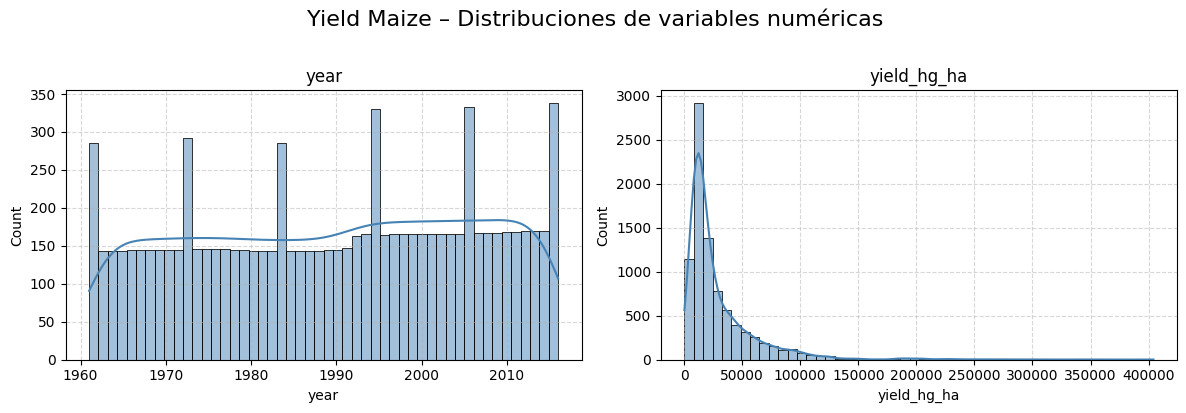

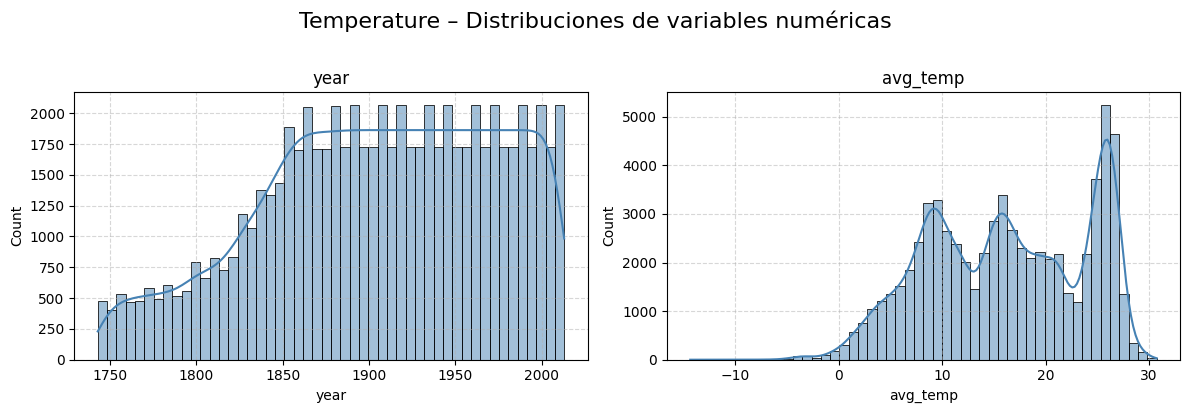

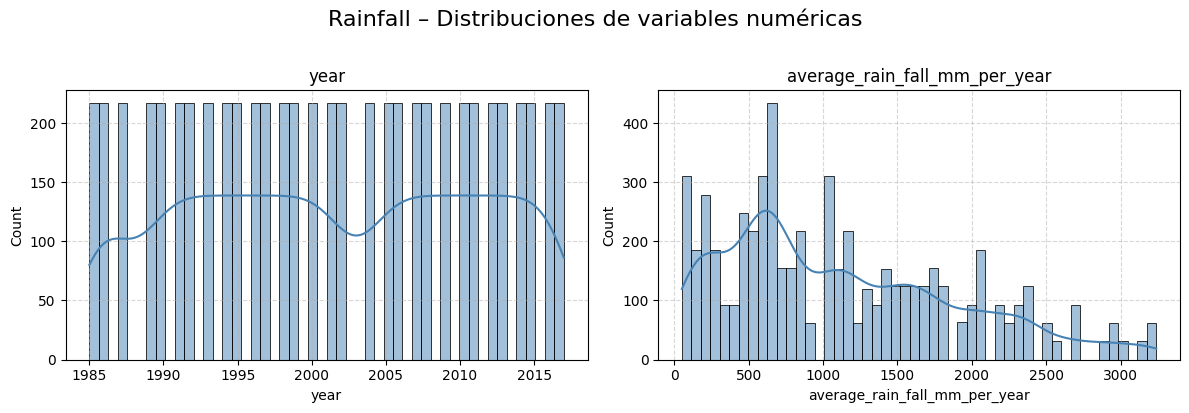

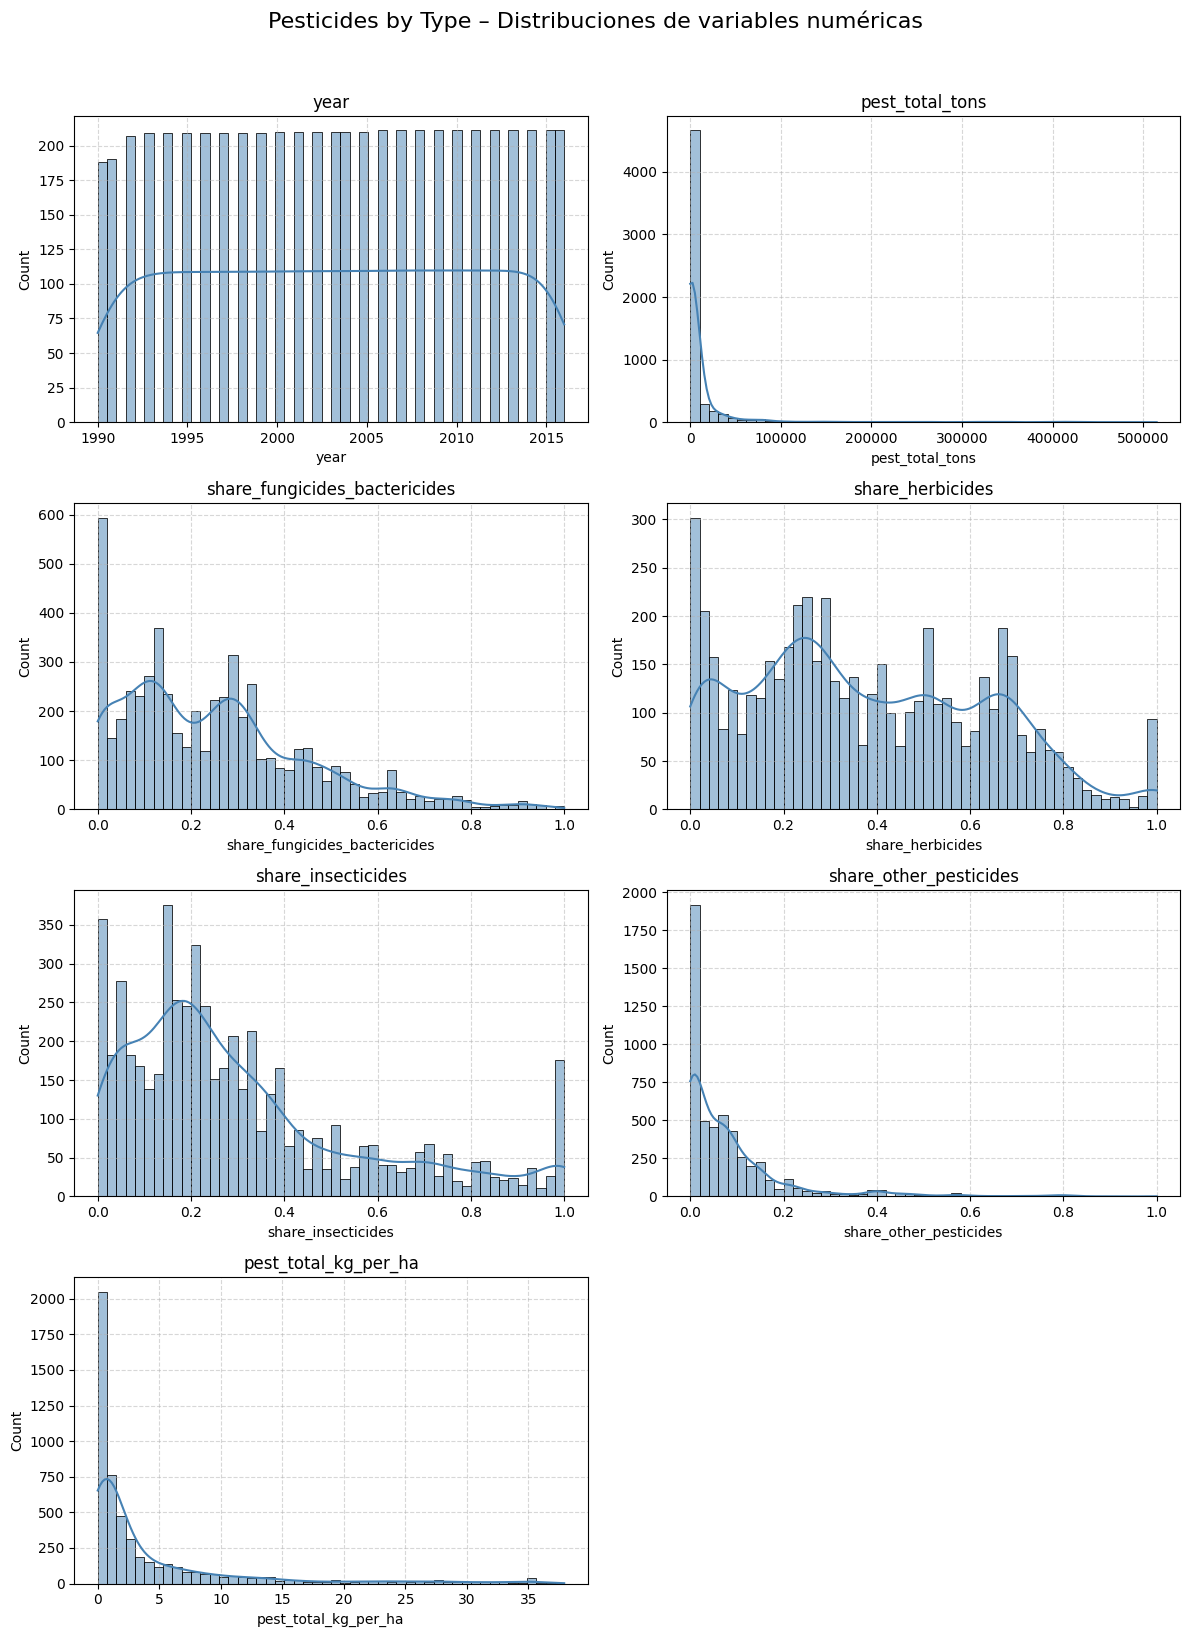

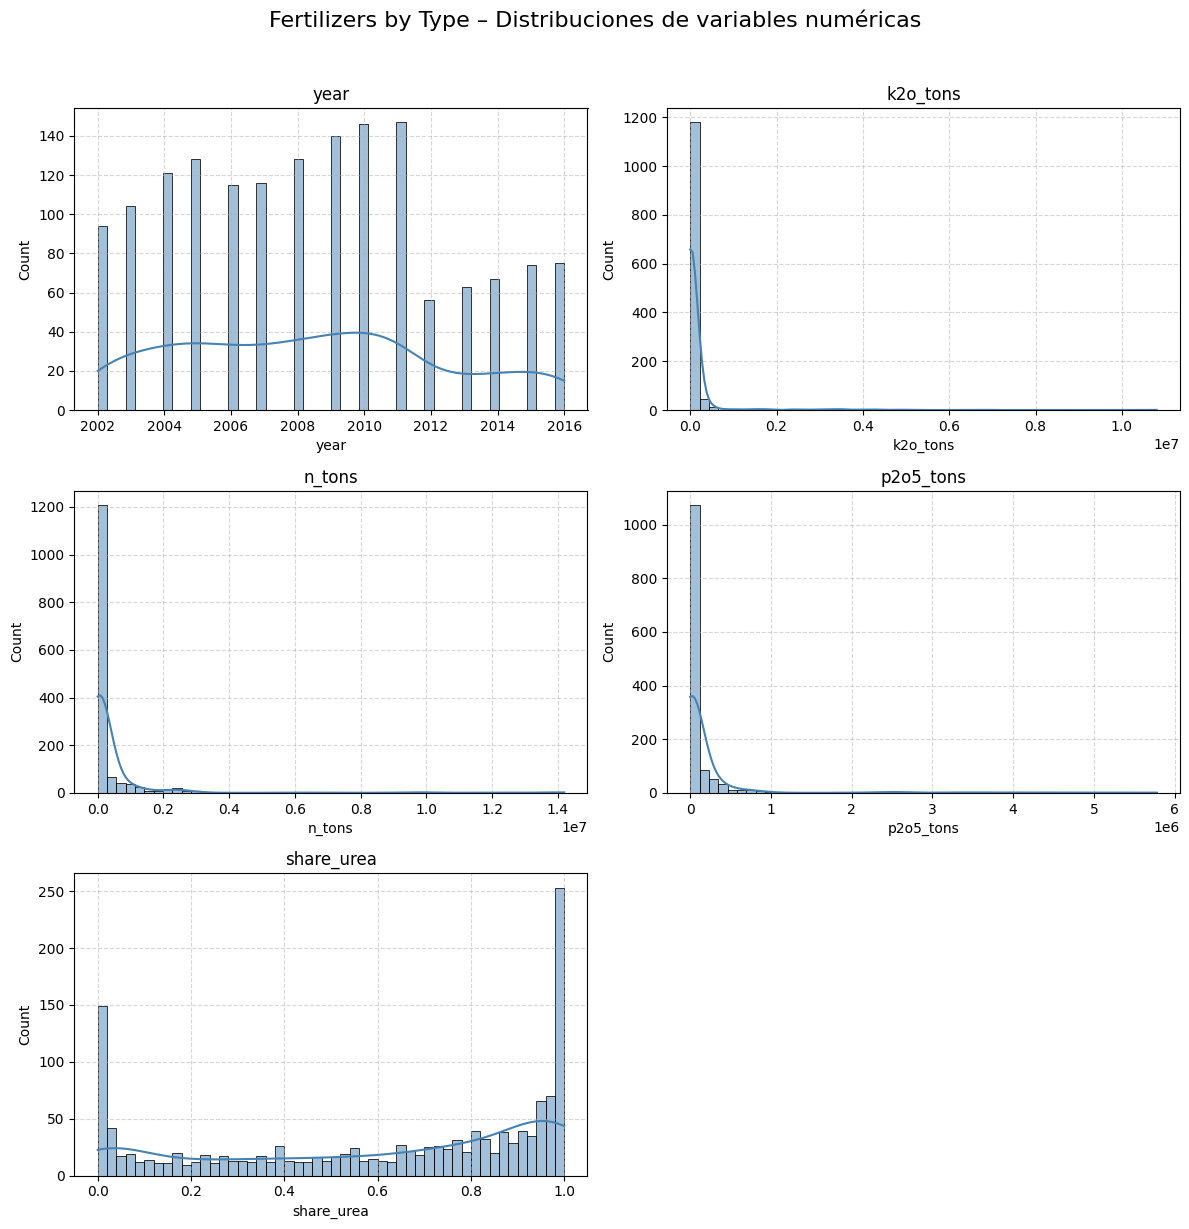

In [36]:
dataframes = {
    'Yield Maize': df_yield_maize,
    'Temperature': df_temp,
    'Rainfall': df_rainfall,
    'Pesticides by Type': pest_features,
    'Fertilizers by Type': fert_features
}

plot_numeric_distributions(dataframes)

##### **Los rangos de datos disponibles varian segun la fuente.**
- Rindes: 1961-2016
- Temperatura: 1743-2013. Mayor concentración de datos a partir de 1850.
- Lluvias: 1985-2017. Cierta caída entre el año 2000 y 2005. Posiblemente hay datos faltantes en esas fechas.
- Pesticidas: 1990-2016
- Fertilizantes: 2002-2016

Al haber muchos mas años de datos en la tabla de temperatura que en las otras tablas, nos puede servir para armar alguna variable de temperatura promedio de largo plazo para cada pais o algun derivado (rolling).

**Con esta disponibilidad temporal de los datos, la propuesta inicial de la Serie es desde 1990-2016.**

Como la serie de temperatura es estable a partir de 1850, la serie de Lluvias empieza en 1985 y la de pesticidas en 1990, vamos a usar los datos desde 1990 en adelante. 

Si bien la serie de temperaturas esta disponible hasta 2013, y esta puede ser una variable clave para tener una buena estimacion del rendimiento, descartar las estimaciones de rendimientos desde 2013-2016 seria un error. Si simulamos lo que ocurriria en la realidad, lo que nos interesa es estimar el periodo mas actual posible. Para esto, vamos a intentar imputar los ultimos 3 años de temperaturas y estimar rendimientos hasta 2016. En caso de que la variable Temperatura sea muy indispensable para la estimacion y tengamos malos resultados, se puede acceder a la pagina donde se cuelgan los datos de temperatura y actualizar la serie (como alternativa si hay tiempo).

Mas adelante podemos tratar de imputar los valores de pesticidas desde 1985-1990 (con valor 0 por su omision o un mean imputer por pais) y alargar la estimacion de la serie para que empiece desde 1985.

---

##### **Resumen general de las distribuciones de variables numericas:**

**`yield`**: Altamente sesgada a la derecha, con muchos valores bajos y unos pocos extremadamente altos (outliers fuertes). Esto indica gran variabilidad en la productividad, posiblemente por diferencias geográficas o económicas. Hay que trabajar el tema de los Outliers, sobre todo si elegimos un modelo lineal.

**`avg_temp`**: Distribución multimodal. Se observan varios picos, lo que podría indicar diferentes zonas climáticas (tropical, templado, etc). Valores entre –14°C y 31°C, logicos para temperatura promedio anual.

**`average_rain_fall_mm_per_year`**: Distribución sesgada a la derecha. Mayor concentración por debajo de los 1300 mm, pero con registros extremos que superan los 3000 mm. Posibles outliers o zonas con climas muy lluviosos.

**`pest_total_tons`**: Distribución extremadamente sesgada a la derecha. La mayoría de los valores son bajos, pero hay valores superiores a 500.000 toneladas, lo que sugiere fuertes outliers. Podrían representar países con uso industrial masivo de pesticidas, o incluso errores de carga.

---

##### **Conclusiones:**
- Trabajar los valores faltantes
- Realizar análisis de outliers (boxplots, IQR). Analizar la opcion de eliminar las colas superiores para `yield`, `pest_total_tons`, `pest_total_kg_per_ha` y todas las variables de fertilizantes (si solo generan ruido o usamos un modelo lineal, de lo contrario no es estrictamente necesario).
- Aplicar transformaciones logarítmicas a `yield` y `pest_total_tons`, `pest_total_kg_per_ha` y todas las variables de fertilizantes para reducir el sesgo en caso de que corresponda.
- Considerar segmentación climática sobre `avg_temp` para mejorar los modelos predictivos.

In [37]:
def filter_from_year(df: pd.DataFrame, start_year: int = 1990, year_col: str = "year") -> pd.DataFrame:
    """Devuelve una copia de *df* dejando solo las filas donde *year_col* ≥ *start_year*."""
    return df[df[year_col] >= start_year].copy()

df_yield_maize = filter_from_year(df_yield_maize)
df_temp = filter_from_year(df_temp)
df_rainfall = filter_from_year(df_rainfall)
pest_features = filter_from_year(pest_features)
df_fertilizers_by_type = filter_from_year(fert_features)

### Base de Temperatura

En el dataset de rendimientos solo tenemos un valor por pais y año.

In [38]:
combinaciones_duplicadas = df_yield_maize[df_yield_maize.duplicated(['country', 'year'], keep=False)]

if combinaciones_duplicadas.empty:
    print("Todo OK: no hay duplicados para country–year")
else:
    print(f"Hay {combinaciones_duplicadas.shape[0]} filas duplicadas en {combinaciones_duplicadas[['country','year']].drop_duplicates().shape[0]} combinaciones:")
    display(combinaciones_duplicadas.sort_values(['country', 'year']))

Todo OK: no hay duplicados para country–year


Mientras que para las temperaturas tenemos muchos valores para el mismo año. Podemos:
* Promediar las temperaturas para cada año, y asi llevarla a la misma granularidad country-year que la variable de rendimiento. 
* Calcular la desviacion estandar de esas temperaturas por año para capturar la variabilidad intra-año. 
* Construir una variable de "anomalía climática" para medir cuán “raro” fue el año para ese país. Esta ultima quedaria en una escala comparable entre países
* Y por ultimo crear "buckets térmicos" con un z-score donde indicamos si un pais tiene temperaturas frias, templadas o calidas, ya que como vimos en el grafico de distribuciones, parece haber 3 tipos de climas distintos y esta variable puede facilitarle el camino a modelos tipo arboles para lograr capturar un resultado mas rapido en instancias iniciales o para capturar no-linealidades en modelos lineales.

In [39]:
g = df_temp.groupby('country')['avg_temp']
missing_stats = pd.DataFrame({'n_missing': g.apply(lambda s: s.isna().sum()),
                              'n_total': g.size(),
                              'pct_missing': g.apply(lambda s: s.isna().mean() * 100)}
                            ).sort_values('n_total', ascending=False)
display(missing_stats.head(7))
del missing_stats, g

,n_missing,n_total,pct_missing
country,,,
United States,0,1248,0.0
China,0,816,0.0
India,0,528,0.0
Brazil,0,264,0.0
Russia,0,216,0.0
Pakistan,0,216,0.0
Mexico,0,192,0.0


Calculamos el promedio y la desviacion estandar de temperatura por pais y año para capturar la variabilidad intra-año. Luego calculamos la media y desviacion de todo el periodo por pais.

In [40]:
annual = df_temp.groupby(["country", "year"])["avg_temp"].agg(temp_mean="mean", temp_std="std").reset_index()

baseline = annual.groupby("country")["temp_mean"].agg(baseline_mean="mean", baseline_std="std").reset_index()

In [41]:
# unimos las tablas y creamos la variable de anomalia termica
temp_features = annual.merge(baseline, on="country", how="left")
temp_features["temp_anomaly_z"] = ((temp_features["temp_mean"] - temp_features["baseline_mean"]) / temp_features["baseline_std"])

In [42]:
# creamos buckets de temperatura
def _bucket(x):
    if x < 10:
        return "cold"
    elif x < 20:
        return "mild"
    return "hot"
    
temp_features["temp_bucket"] = temp_features["temp_mean"].apply(_bucket)
buckets = pd.get_dummies(temp_features["temp_bucket"], prefix="temp")

In [43]:
temp_features = pd.concat([temp_features, buckets], axis=1).drop(columns="temp_bucket")
temp_features = temp_features.drop(columns=["baseline_mean", "baseline_std"])
temp_features

,country,year,temp_mean,temp_std,temp_anomaly_z,temp_cold,temp_hot,temp_mild
0,Afghanistan,1990,15.45,NaN,0.253213,False,False,True
1,Afghanistan,1991,14.57,NaN,-1.402469,False,False,True
2,Afghanistan,1992,14.35,NaN,-1.816390,False,False,True
3,Afghanistan,1993,14.96,NaN,-0.668701,False,False,True
4,Afghanistan,1994,14.94,NaN,-0.706330,False,False,True
...,...,...,...,...,...,...,...,...
3283,Zimbabwe,2009,20.52,NaN,-0.677468,False,True,False
3284,Zimbabwe,2010,21.17,NaN,0.724190,False,True,False
3285,Zimbabwe,2011,20.78,NaN,-0.116805,False,True,False
3286,Zimbabwe,2012,20.52,NaN,-0.677468,False,True,False


In [44]:
# la mayoria de las desviaciones estandar son nan, lo cual indica que solo teniamos 1 valor por pais-año en muchas casos
temp_features.temp_std.isna().mean()

np.float64(0.7153284671532847)

## 3. Analisis de Missing Values

Analizamos la estructura de valores faltantes y valores únicos por dataframe

In [45]:
for name, df in zip(['yield_maize', 'temp', 'rainfall', 'pesticides', 'fertilizers'], 
                    [df_yield_maize, temp_features, df_rainfall, pest_features, fert_features]):
    print(f"\nDataFrame {name}:")
    print("Valores faltantes:")
    display(df.isna().sum())
    print(f"Cantidad de paises: {df.country.nunique()}")


DataFrame yield_maize:
Valores faltantes:


country        0
year           0
yield_hg_ha    0
dtype: int64

Cantidad de paises: 177

DataFrame temp:
Valores faltantes:


country              0
year                 0
temp_mean            0
temp_std          2352
temp_anomaly_z       0
temp_cold            0
temp_hot             0
temp_mild            0
dtype: int64

Cantidad de paises: 137

DataFrame rainfall:
Valores faltantes:


country                            0
year                               0
average_rain_fall_mm_per_year    677
dtype: int64

Cantidad de paises: 217

DataFrame pesticides:
Valores faltantes:


country                            0
year                               0
pest_total_tons                    0
share_fungicides_bactericides    123
share_herbicides                 254
share_insecticides                69
share_other_pesticides           390
pest_total_kg_per_ha             330
dtype: int64

Cantidad de paises: 220

DataFrame fertilizers:
Valores faltantes:


country         0
year            0
k2o_tons      293
n_tons        110
p2o5_tons     248
share_urea    127
dtype: int64

Cantidad de paises: 163


Tenemos menos paises con datos en la tabla de temperatura y fertilizantes que en la tabla de rendimientos. Esto puede ser un problema, ya que si hay paises de los cuales no tenemos valores de ambas variables simultaneamente (temperatura y fertilizantes), probablemente sea dificil estimar un rendimiento para estos casos.

En el set de datos de lluvias hay paises que no tienen datos para todos los años.

In [46]:
g = df_rainfall.groupby('country')['average_rain_fall_mm_per_year']
missing_stats = pd.DataFrame({'n_missing': g.apply(lambda s: s.isna().sum()),
                              'n_total': g.size(),
                              'pct_missing': g.apply(lambda s: s.isna().mean() * 100)}
                            ).sort_values('pct_missing', ascending=False)
display(missing_stats.head(5))
del missing_stats, g

,n_missing,n_total,pct_missing
country,,,
American Samoa,27,27,100.0
Bermuda,27,27,100.0
Aruba,27,27,100.0
Greenland,27,27,100.0
Gibraltar,27,27,100.0


In [47]:
# Combinamos todos los dataframes por las columnas 'year' y 'country' para luego tratar los valores faltantes
df_combined = df_yield_maize.copy()
df_combined = df_combined.merge(temp_features, on=['year', 'country'], how='left')
df_combined = df_combined.merge(df_rainfall, on=['year', 'country'], how='left')
df_combined = df_combined.merge(pest_features, on=['year', 'country'], how='left')
df_combined = df_combined.merge(fert_features, on=['year', 'country'], how='left')

In [48]:
print(f"Dataset combinado:")
print(f"- Dimensiones: {df_combined.shape}")
print(f"- Columnas: {list(df_combined.columns)}")
print(f"- Periodo: {df_combined['year'].min()} - {df_combined['year'].max()}")
print(f"- Países/Areas: {df_combined['country'].nunique()}")

df_combined.head()

Dataset combinado:
- Dimensiones: (4453, 20)
- Columnas: ['country', 'year', 'yield_hg_ha', 'temp_mean', 'temp_std', 'temp_anomaly_z', 'temp_cold', 'temp_hot', 'temp_mild', 'average_rain_fall_mm_per_year', 'pest_total_tons', 'share_fungicides_bactericides', 'share_herbicides', 'share_insecticides', 'share_other_pesticides', 'pest_total_kg_per_ha', 'k2o_tons', 'n_tons', 'p2o5_tons', 'share_urea']
- Periodo: 1990 - 2016
- Países/Areas: 177


,country,year,yield_hg_ha,temp_mean,temp_std,temp_anomaly_z,temp_cold,temp_hot,temp_mild,average_rain_fall_mm_per_year,pest_total_tons,share_fungicides_bactericides,share_herbicides,share_insecticides,share_other_pesticides,pest_total_kg_per_ha,k2o_tons,n_tons,p2o5_tons,share_urea
0,Afghanistan,1990,17582,15.45,NaN,0.253213,False,False,True,327.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,1991,16800,14.57,NaN,-1.402469,False,False,True,327.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,1992,15000,14.35,NaN,-1.816390,False,False,True,327.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,1993,16786,14.96,NaN,-0.668701,False,False,True,327.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,1994,16667,14.94,NaN,-0.706330,False,False,True,327.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
# verificamos que solo hay un dato por pais y año luego de unir todas las bases de datos
df_combined.shape[0] == df_combined[['country', 'year']].drop_duplicates().shape[0]

True

Vemos que hay muchos valores faltantes en muchas de las features. Esto es normal ya que algunas series ya vienen incompletas desde su base:
* Fertilizantes empiezan directamente desde 2002.
* Temperatura solo estan disponibles hasta 2013 y nosotros queremos estimar rendimientos hasta 2016. 
* La serie de lluvias vimos que tiene valores faltantes para todos los años de algunos paises, lo cual sugiere tambien que una posibilidad es acortar el rango de paises a estimar en una primera etapa o armar otro modelo con todos y ver cual responde mejor (es una cuestion del alcance del problema que se quiera resolver).

In [50]:
df_combined.isna().sum().sort_values(ascending=False).head(15)

temp_std                         3773
k2o_tons                         3388
p2o5_tons                        3326
share_urea                       3229
n_tons                           3223
temp_anomaly_z                   2046
temp_cold                        2046
temp_mean                        2046
temp_mild                        2046
temp_hot                         2046
average_rain_fall_mm_per_year     935
share_other_pesticides            627
share_herbicides                  491
share_fungicides_bactericides     360
pest_total_kg_per_ha              323
dtype: int64

In [51]:
df_combined.isna().mean().sort_values(ascending=False)

temp_std                         0.847294
k2o_tons                         0.760835
p2o5_tons                        0.746912
share_urea                       0.725129
n_tons                           0.723782
temp_anomaly_z                   0.459466
temp_cold                        0.459466
temp_mean                        0.459466
temp_mild                        0.459466
temp_hot                         0.459466
average_rain_fall_mm_per_year    0.209971
share_other_pesticides           0.140804
share_herbicides                 0.110263
share_fungicides_bactericides    0.080844
pest_total_kg_per_ha             0.072535
share_insecticides               0.068718
pest_total_tons                  0.066472
yield_hg_ha                      0.000000
country                          0.000000
year                             0.000000
dtype: float64

### Analisis de valores faltantes por paises

* Definimos un set “core” de variables para analizar por pais (temp_mean, average_rain_fall_mm_per_year, pest_total_tons, n_tons, share_urea).
* Excluimos paises si para un conjunto de variables supera, por ejemplo, 50 % de nulos.

In [52]:
CORE_VARS = ["temp_mean", "average_rain_fall_mm_per_year", "pest_total_tons", "n_tons", "share_urea"]
THRESH_PCT = 0.50
MIN_VARS_BAD = 3

In [53]:
null_pct = df_combined.groupby("country")[CORE_VARS].apply(lambda g: g.isna().mean())

vars_above = (null_pct > THRESH_PCT).sum(axis=1)

excluded_countries = vars_above[vars_above >= MIN_VARS_BAD].index

print(f"{len(excluded_countries)} países tienen ≥ {MIN_VARS_BAD} variables core con > {THRESH_PCT:.0%} de nulos. \n")
print("Países excluidos:")
md_list = "\n".join(excluded_countries)
print(md_list)

with open("excluded_countries.md", "w", encoding="utf-8") as f:
    f.write(md_list)

74 países tienen ≥ 3 variables core con > 50% de nulos. 

Países excluidos:
Afghanistan
Antigua and Barbuda
Barbados
Belgium-Luxembourg
Belize
Benin
Bolivia (Plurinational State of)
Bosnia and Herzegovina
Cabo Verde
Cambodia
Chad
China, Taiwan Province of
China, mainland
Comoros
Congo
Costa Rica
Cuba
Czechia
Czechoslovakia
Côte d'Ivoire
Democratic People's Republic of Korea
Democratic Republic of the Congo
Djibouti
Dominica
Eswatini
Ethiopia
Ethiopia PDR
Fiji
French Guiana
Gambia
Grenada
Guam
Guinea-Bissau
Israel
Jordan
Kuwait
Kyrgyzstan
Lao People's Democratic Republic
Luxembourg
Maldives
Micronesia (Federated States of)
Montserrat
Myanmar
Netherlands
New Caledonia
Pacific Islands Trust Territory
Panama
Paraguay
Puerto Rico
Republic of Moldova
Russian Federation
Réunion
Saint Vincent and the Grenadines
Sao Tome and Principe
Serbia and Montenegro
Slovakia
South Sudan
Sudan
Sudan (former)
Syrian Arab Republic
The former Yugoslav Republic of Macedonia
Timor-Leste
Togo
Trinidad and Tobago

Los modelos basados en árboles (LightGBM/XGBoost) toleran nulos aislados. Si una sola variable está muy incompleta (por ej. fertilizantes) pero las demás están bien, podemos imputar 0 y marcar un flag. Pero cuando una variable está vacía al 70...80% para un país, la señal para ese país es casi todo “imputación”, añadiendo ruido sin aportar información real. En este caso vemos que hay varios paises que tienen muchos nulos en mas de 3 variables simultaneamente, por lo que en este punto seria muy imporante definir cual es el camino a seguir.
- a) Se eliminan las variables que son demasiado esparsas, ya que generan problemas.
- b) Eliminamos el conjunto de paises sobre el cual tenemos demasiada poca informacion y estimamos para el resto (menor scope de resolucion pero mas precision).
- c) Dejamos todo y probamos un modelo para ver que tan pobre puede ser su resultado, en este caso seria de la rama de arboles para tolerar tantos valores faltantes/imputados.

Vamos a ir por la opcion b) y eliminamos el conjunto de paises sobre el cual tenemos demasiada poca informacion y estimamos para el resto, asumiendo que cumplimos con el target de nuestros clientes.

In [54]:
df_clean = df_combined[~df_combined.country.isin(excluded_countries)].copy()

In [55]:
df_clean.isna().mean().sort_values(ascending=False)

temp_std                         0.757238
k2o_tons                         0.697476
p2o5_tons                        0.679287
share_urea                       0.664439
n_tons                           0.663697
temp_anomaly_z                   0.158872
temp_cold                        0.158872
temp_mean                        0.158872
temp_mild                        0.158872
temp_hot                         0.158872
share_other_pesticides           0.080549
average_rain_fall_mm_per_year    0.066815
share_herbicides                 0.050483
share_fungicides_bactericides    0.031552
share_insecticides               0.011507
pest_total_tons                  0.009651
pest_total_kg_per_ha             0.009651
yield_hg_ha                      0.000000
country                          0.000000
year                             0.000000
dtype: float64

### Estrategia de imputación para cada tipo de variables

Variables de **Temperatura**: faltan todos los datos desde 2014 a 2016.
1. Interpolamos linealmente o spline (para suavizar los picos) por país (con la serie 1990-2013 → extendemos a 2014-2016).
2. Si un país no tiene datos en toda la serie: imputamos con la media global de 1990-2013.
3. `temp_std`: lo imputamos con el valor 0, ya que estos valores nulos se generaron cuando hubo un unico registro de temperatura por año-pais.
4. Recalculamos los buckets de temperatura (cold/mild/hot)
4. Flag: `temp_imp` (True si se imputó cualquier estadístico).
---
Para la variable de **Lluvia**, que tiene nulos en medio de la serie:
1. Interpolación temporal spline/lineal por país.
2. si hay nulos residuales < 3-5 % → rellenamos con la mediana histórica del país.
3. Flag: `rain_imp`.
---
Variables de **Pesticidas y shares de pesticidas**:
1. Asumimos 0 = no uso / no hay dato, para los totales e intensidades.
2. Si `pest_total_tons` imputa 0 → shares = 0.
3. Flag: `pest_imp` (True si se puso 0 por falta de dato).
4. `share_imp_*` (con uno global alcanza)
---
Variables de **Fertilizantes**: faltan todos los datos desde 1990 a 2001.
Aca tenemos dos caminos:
1. Trabajar con un modelo “full-years” (1990-2016):
* Imputamos con 0 + flags `fert_imp_*` → el modelo aprenderá a ignorar cuando no hay insumos.
2. Modelo “fert-window” (2002-2016):
* Filtramos el dataset para quedarnos solo con los años con fertilizantes reales (sin grandes imputaciones).

> Si tenemos tiempo podemos entrenar ambos y comparar RMSE. Pero para iniciar vamos con la opcion 1.

---

Justificaciones de cada tecnica:
* con la **interpolación temporal** nos apoyamos en la suavidad inter-anual de clima y lluvia.
* Es comun **imputar 0 en insumos** cuando la falta de los registros suele indicar "no uso".
* Los **Flags booleanos** nos permiten que un modelo tipo LightGBM aprenda a ponderar (o ignorar) los valores imputados sin perder filas.
* Si tenemos **dos ventanas de entrenamiento**, en una evitamos descartar información de yield pre-2002, y la otra nos permite medir el valor agregado del set de datos de fertilizantes.

In [56]:
# creamos la funcion para interpolar las variables de clima y lluvia
def _spline_interpolate(series, order=2):
    """Interpola una serie temporal con splines de orden *order* y rellena huecos iniciales/finales (both)"""
    return series.sort_index().interpolate(method="spline", order=order, limit_direction="both")

In [57]:
def interpolate_by_country(df, col):
    """Interpola la columna *col* con splines dentro de cada país y mantiene el índice original."""
    return df.sort_values("year").groupby("country")[col].transform(_spline_interpolate)

In [58]:
df_imputed = df_clean.copy()

In [59]:
temp_cols = ["temp_mean", "temp_std", "temp_anomaly_z", "temp_cold", "temp_mild", "temp_hot"]

# flag imputation para las variables de temperatura
temp_flag = df_imputed[temp_cols].isna().any(axis=1).astype("uint8")

In [60]:
# interpolamos la variable temp_mean
df_imputed["temp_mean"] = interpolate_by_country(df_imputed, "temp_mean")

In [61]:
# interpolamos la variable temp_std con spline. Para los NaNs finales → 0. Hago esto para que no sea tan brusco el cambio de la variable.
df_imputed["temp_std"]  = interpolate_by_country(df_imputed, "temp_std").fillna(0.0)

In [62]:
# recalcular anomalía z
baseline = df_imputed.groupby("country")["temp_mean"].agg(["mean", "std"])

df_imputed = df_imputed.join(baseline, on="country")

df_imputed["temp_anomaly_z"] = (df_imputed["temp_mean"] - df_imputed["mean"]) / df_imputed["std"]

df_imputed.drop(columns=["mean", "std"], inplace=True)

In [63]:
# recalculamos los buckets de temperatura
df_imputed["temp_cold"] = (df_imputed["temp_mean"] < 10).astype("uint8")

df_imputed["temp_mild"] = (df_imputed["temp_mean"].between(10, 20, inclusive="left")).astype("uint8")

df_imputed["temp_hot"]  = (df_imputed["temp_mean"] >= 20).astype("uint8")

df_imputed["temp_imp"] = temp_flag.astype("uint8")

In [64]:
rain_col = "average_rain_fall_mm_per_year"

rain_flag = df_imputed[rain_col].isna()

df_imputed[rain_col] = interpolate_by_country(df_imputed, rain_col)

In [ ]:
# si todavía quedan NaN (ejemplo, paises sin datos), mediana país → mediana global
country_median = df_imputed.groupby("country")[rain_col].transform("median")

global_median  = df_imputed[rain_col].median()

df_imputed[rain_col] = df_imputed[rain_col].fillna(country_median)
df_imputed[rain_col] = df_imputed[rain_col].fillna(global_median)

df_imputed["rain_imp"] = rain_flag.astype("uint8")

C:\Users\Nacho\AppData\Local\Temp\ipykernel_29868\3963700891.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_imputed[rain_col].fillna(country_median, inplace=True)
C:\Users\Nacho\AppData\Local\Temp\ipykernel_29868\3963700891.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

In [66]:
pest_totals = ["pest_total_tons", "pest_total_kg_per_ha"]
pest_shares = ["share_insecticides", "share_herbicides", "share_fungicides_bactericides", "share_other_pesticides"]

pest_flag = df_imputed[pest_totals + pest_shares].isna().any(axis=1)

df_imputed[pest_totals + pest_shares] = df_imputed[pest_totals + pest_shares].fillna(0.0)

df_imputed["pest_imp"] = pest_flag.astype("uint8")

In [67]:
fert_totals = ["n_tons", "p2o5_tons", "k2o_tons"]
fert_share = ["share_urea"]
fert_cols = fert_totals + fert_share

fert_flag = df_imputed[fert_cols].isna().any(axis=1)

df_imputed[fert_cols] = df_imputed[fert_cols].fillna(0.0)
df_imputed["fert_imp"] = fert_flag.astype("uint8")

In [ ]:
# todavia me falta de resolver algunos casos puntuales de imputacion en la media. 
# Nota, tengo que hacer un fallback en caso de que no se completen los nulos con la interpolacion.
df_imputed.isna().sum()

country                            0
year                               0
yield_hg_ha                        0
temp_mean                        134
temp_std                           0
temp_anomaly_z                   134
temp_cold                          0
temp_hot                           0
temp_mild                          0
average_rain_fall_mm_per_year      0
pest_total_tons                    0
share_fungicides_bactericides      0
share_herbicides                   0
share_insecticides                 0
share_other_pesticides             0
pest_total_kg_per_ha               0
k2o_tons                           0
n_tons                             0
p2o5_tons                          0
share_urea                         0
temp_imp                           0
rain_imp                           0
pest_imp                           0
fert_imp                           0
dtype: int64

### Tabla resumen de la estrategia de imputación aplicada (dataset 1990-2016)

| variable / grupo | % NaN inicial | Imputación | Flag |
|------------------|--------------:|------------|------|
| `temp_mean`, `temp_std`, `temp_anomaly_z`, `temp_cold/mild/hot` | `temp_std` 76 % <br>- resto 15 %| Interpolación spline por país.<br>NaNs residuales (solo `temp_std`) → 0.<br>Recalculo de anomalía y buckets. | `temp_imp` |
| `average_rain_fall_mm_per_year` | 6.7 % | Spline por país → mediana histórica del país.<br>Preservamos la suavidad y evitamos datos de otros países. | `rain_imp` |
| Pesticidas (`pest_total_tons/_kg_per_ha`, `share_*`) | 1-8 % | NaNs → 0 (se asume “no uso / no dato”). <br>Shares coherentes. | `pest_imp` |
| Fertilizantes (`n_tons`, `p2o5_tons`, `k2o_tons`, `share_urea`) | 66-70 % | NaNs → 0 (sin dato ⇒ sin aplicación). | `fert_imp` |

- **Spline (orden 2)** suavizamos los picos inter-anuales. Es apropiado para clima y lluvia.  
- **Mediana país** para lluvia cubre los huecos al < 3-5 %.  
- **Flags `*_imp`** permiten que el modelo aprenda a ponderar casos imputados sin descartar filas.  
- Se excluyeron *74 países* con ≥ 3 variables “core” con > 50 % de nulos (listado en `excluded_countries.md`).

> Rutas de mejora: probar modelo alternativo 2002-2016 (sin grandes imputaciones de fertilizantes) y comparar métricas (RMSE, R²).


In [ ]:
# Lag temporal: Los efectos de fertilizantes suelen verse el mismo año, 
# pero si las estadísticas agrícolas oficiales son reportadas con retraso, tenemos que considerar desplazar +1 año.
# Tengo que evaluar la importancia con un modelo de árbol (Random Forest / XGBoost) para confirmar qué familias realmente explican variación en el target.

In [ ]:
# transformaciones a aplicar para normalizar las variables
# pest_features['pest_total_kg_per_ha_log'] = np.log1p(pest_features['pest_total_kg_per_ha'])

In [ ]:
# for col in ("N_total", "P2O5_total", "K2O_total"):
#     fert_features[f"log1p_{col}"] = np.log1p(fert_features[col])